# Spherical droplet benchmark

To check in a realistic setting what errors in curvature (and, subsequently, anisotropic stress) we get through noisy image data, we run the stress analysis on droplets in force-free environments. For this, we evaluate a droplet embued in agarose. The data we use for this is provided [here](https://github.com/ElijahShelton/drop-recon/tree/master/tifs%20for%20test) under a [academic use license](https://github.com/ElijahShelton/drop-recon?tab=License-1-ov-file#readme).

According to the passed information, the metadata for this file are as follows:

```
filename: drop_in_agarose.tif
voxel size in x & y: 0.4151 um
voxel size in z: 1 um
```

In [1]:
import napari
from napari.layers import Layer
from skimage import io
import requests
import numpy as np
import scipy.ndimage as ndi

from napari_stress import reconstruction, measurements, __version__
from matplotlib import pyplot as plt

In [2]:
print(f'napari-stress version: {__version__}')

napari-stress version: 0.3.9


In [3]:
viewer = napari.Viewer(ndisplay=3)

## Load the image

In [4]:
url = r'https://github.com/ElijahShelton/drop-recon/raw/refs/heads/master/tifs%20for%20test/drop_in_agarose.tif'
response = requests.get(url)

# Step 2: Save the file locally
with open('drop_in_agarose.tif', 'wb') as file:
    file.write(response.content)

# Step 3: Load the .tif file into a NumPy array
image_array = io.imread('drop_in_agarose.tif')

scale = np.asarray([1, 0.4151, 0.4151])

## Reconstruct droplet

In [5]:
reconstruction_results = reconstruction.reconstruct_droplet(
    image_array,
    voxelsize = scale,
    target_voxelsize = 0.4151,
    resampling_length = 1.0,
    edge_type = 'surface',
    trace_length = 20,
    use_dask=False
)

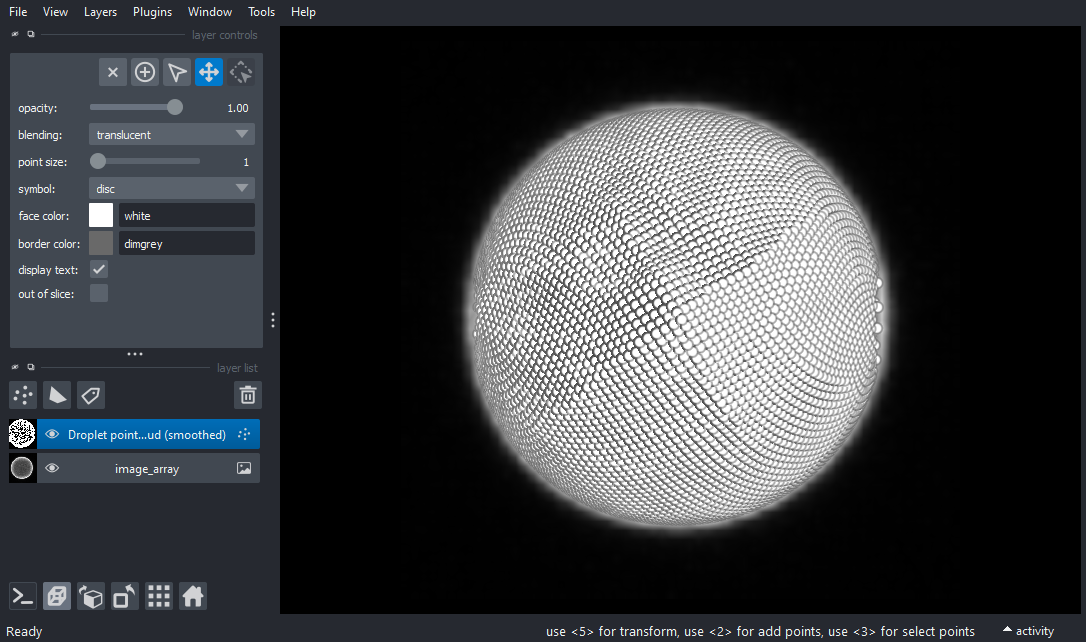

In [6]:
viewer.layers.clear()
viewer.add_image(image_array, scale=scale)
viewer.add_layer(Layer.create(*reconstruction_results[-1]))
napari.utils.nbscreenshot(viewer)

## Quantify errors: Radii

The first thing we'll look at is to compare the radii of all the points on the surface of the droplet. As a reference point for the center of the sphere, we will use the image's intensity-weighted center of mass. However, keep in mind that this is not super informative as it doesn't give us a relative error for the measurement.

In [7]:
points_reconstructed = reconstruction_results[-1][0]

In [8]:
# calculate the intensity weighted center of mass of the image
center_of_mass =  ndi.center_of_mass(image_array) * scale
radii = np.linalg.norm(points_reconstructed - center_of_mass, axis=1)
radius_mean = np.mean(radii)
radius_std = np.std(radii)

relative_error_radius = np.abs(radii - radius_mean) / radius_mean

Text(0, 0.5, 'Count')

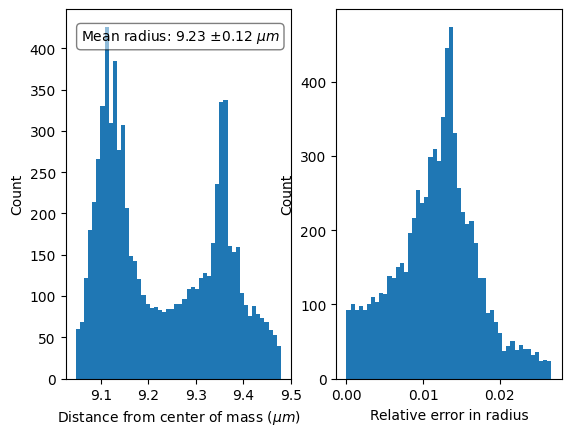

In [9]:

fig, axes = plt.subplots(ncols=2)
_ = axes[0].hist(radii, bins=50, density=False)
# Add a textbox with mean and std inside the plot
textstr = f"Mean radius: {radius_mean:.2f} $\pm ${radius_std:.2f} $\mu m$"
axes[0].text(0.95, 0.95, textstr, transform=axes[0].transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

axes[0].set_xlabel('Distance from center of mass ($\mu m$)')
axes[0].set_ylabel('Count')

_ = axes[1].hist(relative_error_radius, bins=50, density=False)
axes[1].set_xlabel('Relative error in radius')
axes[1].set_ylabel('Count')

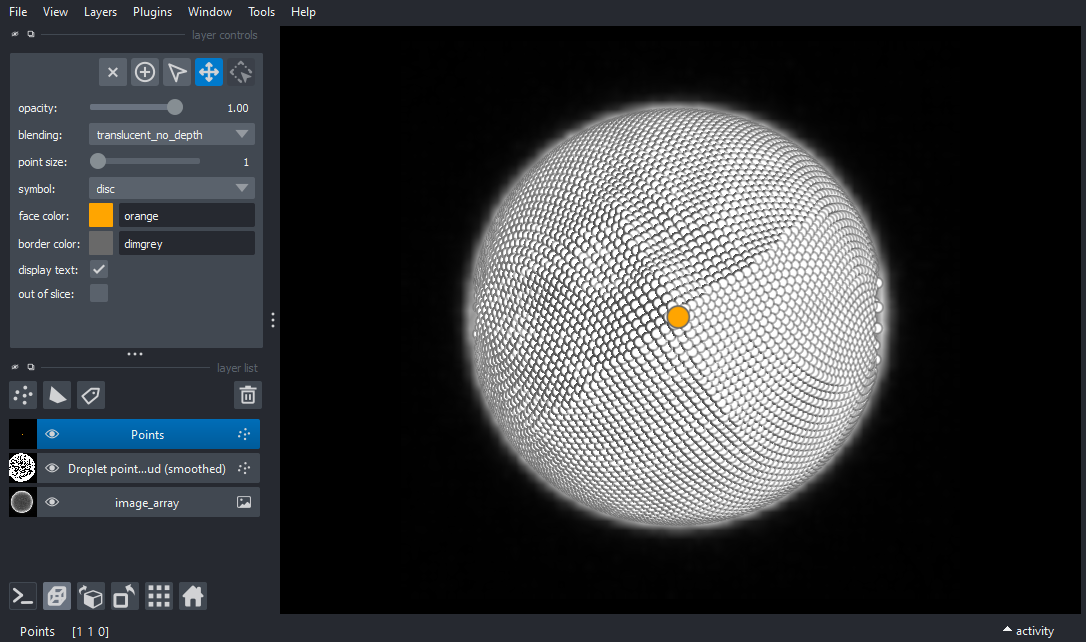

In [10]:
viewer.add_points(center_of_mass, size=1, blending='translucent_no_depth', face_color='orange')
napari.utils.nbscreenshot(viewer)

## Quantify errors: Curvature

What's a better estimate for the error is the *curvature* of the object. For a spherical object of radius *R*, the curvature at any point of the surface is given by 

$$
H = \frac{1}{R}
$$

In [11]:
# TODO: Replace by LebedevExpander later - will make execution of notebook much faster
measurements_results = measurements.comprehensive_analysis(
    points_reconstructed,
    max_degree=20,
    n_quadrature_points=5810,
    gamma=1.0,
)

Error in PyGeodesicAlgorithmExact.geodesicDistances: zero-size array to reduction operation minimum which has no identity


In [15]:
viewer.add_layer(Layer.create(*measurements_results[4]))

<Points layer 'Result of lebedev quadrature (droplet) [1]' at 0x24602a56910>

In [16]:
mean_curvature = measurements_results[4][1]['features']['mean_curvature']
mean_curvature_reference = 1/ radius_mean

relative_error = np.abs(mean_curvature - mean_curvature_reference) / mean_curvature_reference

Text(0, 0.5, 'Count')

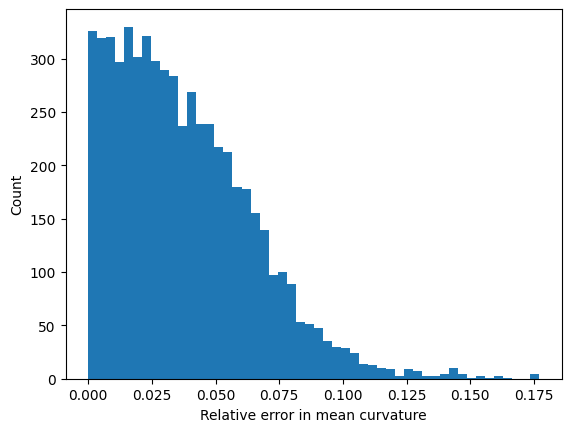

In [14]:
fig, ax = plt.subplots()
_ = ax.hist(relative_error, bins=50, density=False)

ax.set_xlabel('Relative error in mean curvature')
ax.set_ylabel('Count')